In [1]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy import stats
import random
from bisect import bisect_left



In [2]:
PATH = os.getcwd()
DLaaS_filename_1 = PATH + "/../data/df.test.csv"
DLaaS_filename_2 = PATH + "/../data/df.train.csv"
DLaaS_long_traces = PATH + "/../data/DLaaS_long.csv"

## 1. Read data

In [3]:
LOAD=False
if LOAD:
    df = pd.concat([pd.read_csv(DLaaS_filename_1),pd.read_csv(DLaaS_filename_2)])
    ids = df["pod.id"].unique()
    DLaaS_cpu_pod_id,DLaaS_mem_pod_id = set(),set()
    for pod_id in ids:
        if(len(df[df["pod.id"]==pod_id]["cpu.usage"].values)>100): #save time series greater than 100 timesteps
            DLaaS_cpu_pod_id.add(pod_id)
        if(len(df[df["pod.id"]==pod_id]["mem.current"].values)>100): #save time series greater than 100 timesteps
            DLaaS_mem_pod_id.add(pod_id)
    pod_ids_long = DLaaS_cpu_pod_id.intersection(DLaaS_mem_pod_id)
    df = df[df["pod.id"].isin(pod_ids_long)]
    df.to_csv(DLaaS_long_traces)
    
df = pd.read_csv(DLaaS_long_traces)
DLaaS_cpu_ts, DLaaS_mem_ts = [],[]
ids = df["pod.id"].unique()
for pod_id in ids:
    DLaaS_cpu_ts.append(df[df["pod.id"]==pod_id]["cpu.usage"].values)
    DLaaS_mem_ts.append(df[df["pod.id"]==pod_id]["mem.current"].values)
        

## 2. Inspect data and asses global variables

We are interesting in observing the CPU and MEM values that we will be tackling in order to set the number and size of the buckets.

In [4]:
CPU_values = np.concatenate(DLaaS_cpu_ts)
MEM_values = np.concatenate(DLaaS_mem_ts)

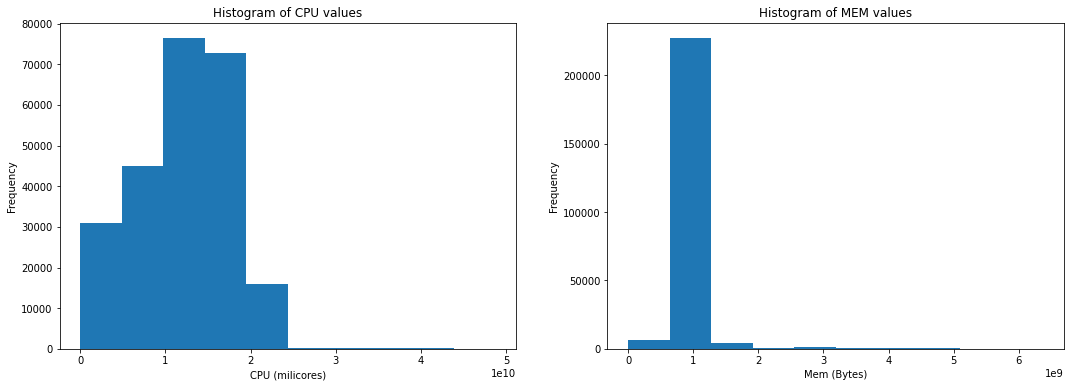

In [5]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.hist(CPU_values)
plt.title("Histogram of CPU values")
plt.xlabel("CPU (milicores)")
plt.ylabel("Frequency")
plt.subplot(122)
plt.hist(MEM_values)
plt.title("Histogram of MEM values")
plt.xlabel("Mem (Bytes)")
plt.ylabel("Frequency")
plt.show()

In [6]:
a = stats.describe(CPU_values)._asdict()
pd.DataFrame(a).iloc[0].append(pd.Series([np.std(CPU_values)], index=["standard dev"]))

nobs            2.416270e+05
minmax          5.189558e+06
mean            1.196643e+10
variance        3.278101e+19
skewness       -3.503293e-01
kurtosis       -1.610183e-01
standard dev    5.725459e+09
dtype: float64

In [7]:
a = stats.describe(MEM_values)._asdict()
pd.DataFrame(a).iloc[0].append(pd.Series([np.std(MEM_values)], index=["standard dev"]))

nobs            2.416270e+05
minmax          1.765376e+06
mean            1.127439e+09
variance        1.068418e+17
skewness        5.528083e+00
kurtosis        5.779693e+01
standard dev    3.268660e+08
dtype: float64

In [8]:
RESOLUTION = 20 #number of timesteps in time window
MAX_CPU, MIN_CPU = max([max(ts) for ts in DLaaS_cpu_ts]), min([min(ts) for ts in DLaaS_cpu_ts])
MAX_MEM, MIN_MEM = max([max(ts) for ts in DLaaS_mem_ts]), min([min(ts) for ts in DLaaS_mem_ts])

In [9]:
MAX_TS = max([len(ts) for ts in DLaaS_cpu_ts])
MAX_time = ((MAX_TS*15)/60)/60
print("The longest trace lasts {} hours".format(MAX_time))

The longest trace lasts 17.4375 hours


## 2. Preprocessing: aggregate signal

In [10]:
y_cpu = DLaaS_cpu_ts[0]
y_mem = DLaaS_mem_ts[0]

In [11]:
NUM_BUCKETS = 400 # same as google
BUCKET_SIZE_CPU = (MAX_CPU- abs(MIN_CPU))/NUM_BUCKETS
BUCKET_SIZE_MEM = (MAX_MEM- abs(MIN_MEM))/NUM_BUCKETS
CPU_BUCKETS = np.linspace(MIN_CPU+BUCKET_SIZE_CPU, MAX_CPU, num=NUM_BUCKETS)
MEM_BUCKETS = np.linspace(MIN_MEM+BUCKET_SIZE_MEM, MAX_MEM, num=NUM_BUCKETS)
CPU_BINS = np.linspace(MIN_CPU, MAX_CPU, num=NUM_BUCKETS+1)
MEM_BINS = np.linspace(MIN_MEM, MAX_MEM, num=NUM_BUCKETS+1)

In [12]:
def get_peak_in_hist(hist):
    #get the index of the higher non empty bucket in histogram
    return max([i for i,e in enumerate(hist) if e!=0])

In [13]:
def get_aggregated_signal_cpu(trace):
    num_windows = int(np.floor((len(trace))/RESOLUTION))
    agg_signal = []
    for t in range(num_windows): #for each of the windows
        window_hist = np.histogram(trace[t*RESOLUTION:(t*RESOLUTION+RESOLUTION)], bins=CPU_BINS)[0] #compute the histogram per window
        agg_signal.append(window_hist)
    if len(trace)%RESOLUTION != 0:#there are some timesteps missing in the aggregated signal
        t +=1
        window_hist = np.histogram(trace[t*RESOLUTION:(t*RESOLUTION+(int(len(trace))%RESOLUTION))], bins=CPU_BINS)[0]
        agg_signal.append(window_hist)
    return agg_signal

In [14]:
def get_aggregated_signal_mem(trace):
    num_windows = int(np.floor((len(trace))/RESOLUTION))
    agg_signal = []
    for t in range(num_windows): #for each of the windows
        window_hist = np.histogram(trace[t*RESOLUTION:(t*RESOLUTION+RESOLUTION)], bins=MEM_BINS)[0] #compute the histogram per window
        peak = get_peak_in_hist(window_hist)
        window_peak_hist = np.zeros(NUM_BUCKETS)
        window_peak_hist[peak]=1
        agg_signal.append(window_peak_hist)
    if len(trace)%RESOLUTION != 0:#there are some timesteps missing in the aggregated signal
        t +=1
        window_hist = np.histogram(trace[t*RESOLUTION:(t*RESOLUTION+(int(len(trace))%RESOLUTION))], bins=MEM_BINS)[0]
        peak = get_peak_in_hist(window_hist)
        window_peak_hist = np.zeros(NUM_BUCKETS)
        window_peak_hist[peak]=1
        agg_signal.append(window_peak_hist)
    return agg_signal

In [15]:
DLaaS_cpu_agg, DLaaS_mem_agg = [],[]
for trace in DLaaS_cpu_ts:
    DLaaS_cpu_agg.append(get_aggregated_signal_cpu(trace))
for trace in DLaaS_mem_ts:
    DLaaS_mem_agg.append(get_aggregated_signal_mem(trace))

## 3. Moving window recommenders

### 3.1 Implementation

In [16]:
N = 12
HALF_LIFE_CPU = 8 #1-hour half life
HALF_LIFE_MEM = 12#2-hour half life
J_CPU = 98
J_MEM = 100
MARGIN = 0.1

In [17]:
def get_decay(tau, half_life):
    '''Computes the exponentially decaying weight
        Returns:
        exponent on base 2 of - tau divided by the half time
    '''
    return 2**-(tau/half_life)

In [18]:
def get_granular_rec(rec, warmup):
    return np.concatenate((np.repeat(np.array(warmup),RESOLUTION),np.repeat(rec,RESOLUTION)))

In [19]:
def get_peak_rec(agg_trace,buckets):
    rec = []
    for t in range(len(agg_trace)):
        last = max(0, t -(N -1))   
        peak_idx = max([get_peak_in_hist(hist)for hist in agg_trace[last:t+1]])
        rec.append(buckets[peak_idx])
    return rec

In [20]:
def average_use_of_histogram(hist,buckets):
    '''Computes the average use of histograms as in formula 2 of autopilot paper
    '''
    numerator, denominator = 0,0
    for j in range(NUM_BUCKETS):
        numerator += buckets[j]*hist[j]
        denominator +=hist[j]
        
    return numerator/denominator

In [21]:
def get_wavg_rec(agg_trace,buckets, half_life):
    rec = []
    denominator = sum([get_decay(tau, half_life) for tau in range(N+1)])
    for t in range(len(agg_trace)):
        numerator = sum([get_decay(tau, half_life)*average_use_of_histogram(agg_trace[t-tau],buckets) for tau in range(t+1)])
        rec.append(numerator/denominator)
    return rec

In [22]:
def get_decayed_hist(agg_trace,t, buckets,prev,half_life):
    if t==0:
        return buckets*1*agg_trace[0]#decay is 1
    else:
        #print(get_decay(t, half_life))
        return prev + buckets*get_decay(t, half_life)*agg_trace[t]
    

In [23]:
def get_jp_rec(agg_trace,buckets, half_life,perc):
    rec = []
    adj_hist = np.zeros(NUM_BUCKETS)
    for t in range(len(agg_trace)):
        adj_hist = get_decayed_hist(agg_trace,t,buckets,adj_hist,half_life)
        rec.append(np.percentile(adj_hist,perc))
    return rec

In [24]:
#get_jp_rec(DLaaS_cpu_agg[0],CPU_BUCKETS, HALF_LIFE_CPU)

### 3.2 Test traces

In [25]:
random.seed(42)
sample_traces = random.sample(range(len(DLaaS_cpu_ts)), 4)

In [26]:
peak_rec_cpu = [get_granular_rec(get_peak_rec(DLaaS_cpu_agg[i],CPU_BUCKETS),np.mean(CPU_values)) for i in sample_traces]
peak_rec_mem = [get_granular_rec(get_peak_rec(DLaaS_mem_agg[i],MEM_BUCKETS),np.mean(MEM_values)) for i in sample_traces]
wavg_rec_cpu = [get_granular_rec(get_wavg_rec(DLaaS_cpu_agg[i],CPU_BUCKETS,HALF_LIFE_CPU),np.mean(CPU_values)) for i in sample_traces]
wavg_rec_mem = [get_granular_rec(get_wavg_rec(DLaaS_mem_agg[i],MEM_BUCKETS,HALF_LIFE_MEM),np.mean(MEM_values)) for i in sample_traces]
jp_rec_cpu = [get_granular_rec(get_jp_rec(DLaaS_cpu_agg[i],CPU_BUCKETS,HALF_LIFE_CPU, J_CPU),np.mean(CPU_values)) for i in sample_traces]
jp_rec_mem = [get_granular_rec(get_jp_rec(DLaaS_mem_agg[i],MEM_BUCKETS,HALF_LIFE_MEM, J_MEM),np.mean(MEM_values)) for i in sample_traces]

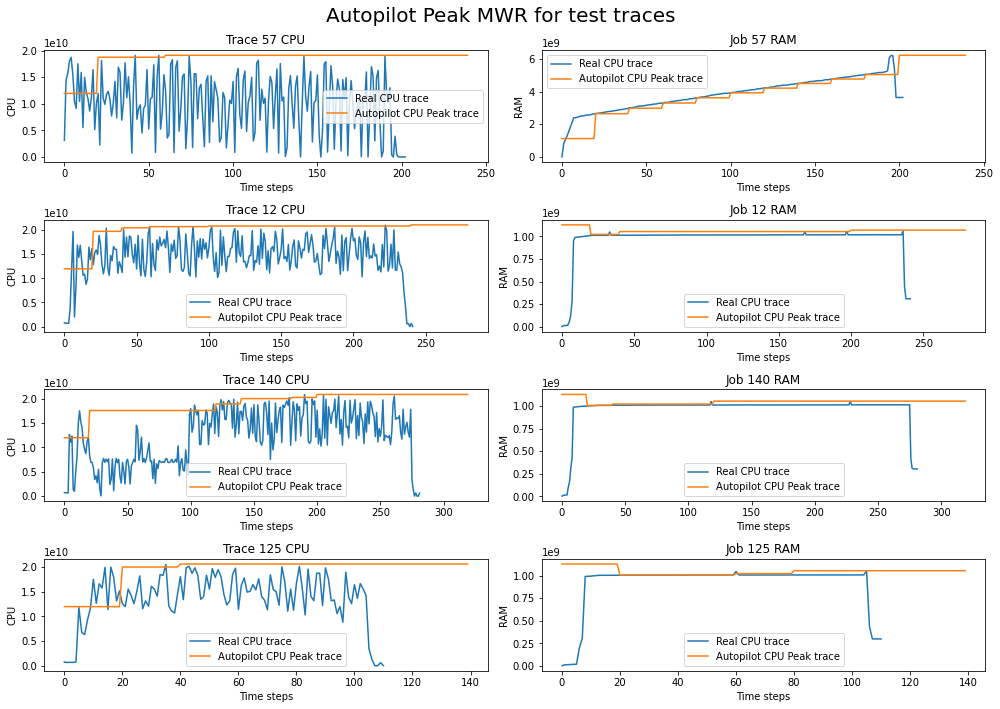

In [27]:
plt.figure(figsize = (14, 10))
plt.suptitle("Autopilot Peak MWR for test traces", size=20)
for i, trace_id in enumerate(sample_traces):
    plt.subplot(420+i*2+1)
    plt.plot(DLaaS_cpu_ts[trace_id], label="Real CPU trace")
    plt.plot(peak_rec_cpu[i], label="Autopilot CPU Peak trace")
    plt.title("Trace "+str(trace_id)+ " CPU")
    plt.xlabel("Time steps")
    plt.ylabel("CPU")
    plt.legend()
    plt.subplot(420+i*2+2)
    plt.plot(DLaaS_mem_ts[trace_id], label="Real CPU trace")
    plt.plot(peak_rec_mem[i], label="Autopilot CPU Peak trace")    
    plt.legend()
    plt.title("Job "+str(trace_id) + " RAM")
    plt.xlabel("Time steps")
    plt.ylabel("RAM")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.savefig(OUTPUT_DIRECTORY+ 'Autopilot_peak_test_traces.png')



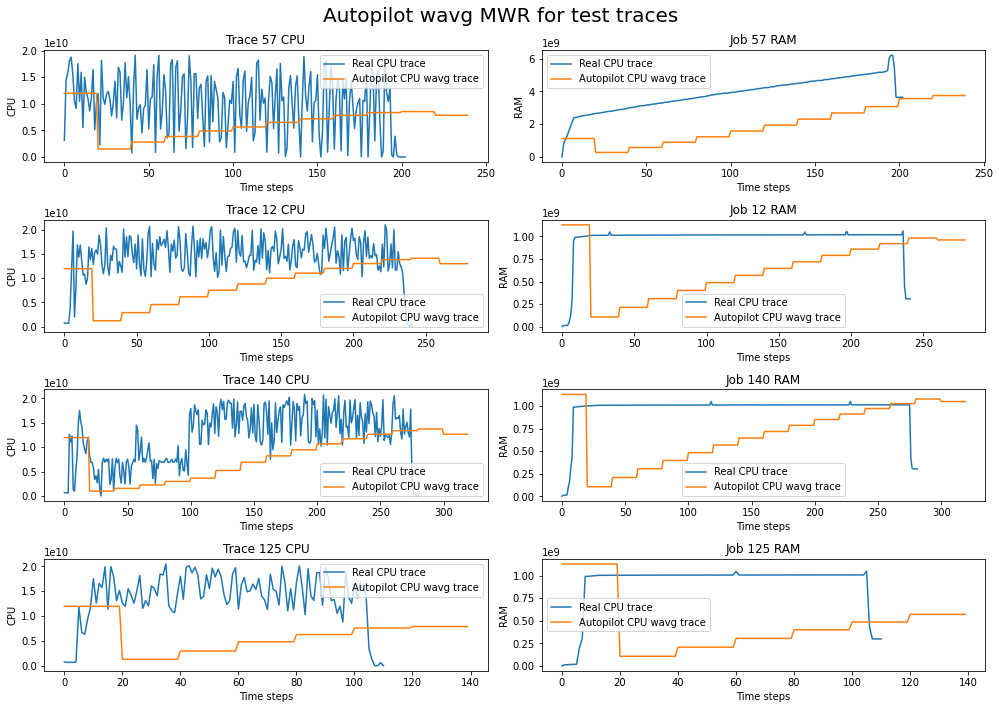

In [28]:
plt.figure(figsize = (14, 10))
plt.suptitle("Autopilot wavg MWR for test traces", size=20)
for i, trace_id in enumerate(sample_traces):
    plt.subplot(420+i*2+1)
    plt.plot(DLaaS_cpu_ts[trace_id], label="Real CPU trace")
    plt.plot(wavg_rec_cpu[i], label="Autopilot CPU wavg trace")
    plt.title("Trace "+str(trace_id)+ " CPU")
    plt.xlabel("Time steps")
    plt.ylabel("CPU")
    plt.legend()
    plt.subplot(420+i*2+2)
    plt.plot(DLaaS_mem_ts[trace_id], label="Real CPU trace")
    plt.plot(wavg_rec_mem[i], label="Autopilot CPU wavg trace")    
    plt.legend()
    plt.title("Job "+str(trace_id) + " RAM")
    plt.xlabel("Time steps")
    plt.ylabel("RAM")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.savefig(OUTPUT_DIRECTORY+ 'Autopilot_wavg_test_traces.png')



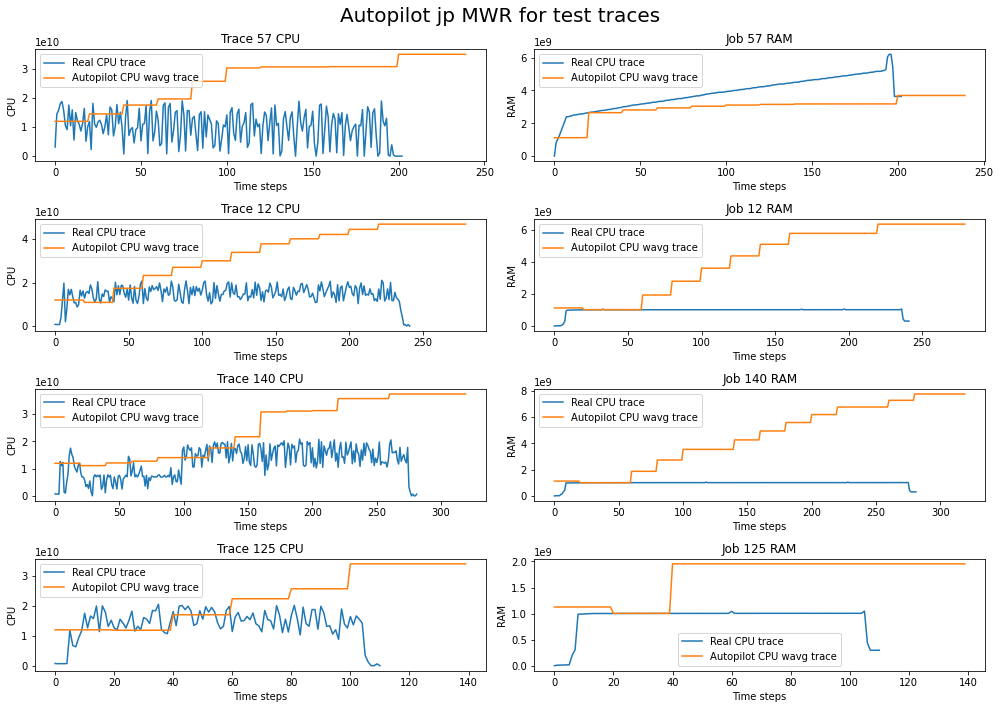

In [29]:
plt.figure(figsize = (14, 10))
plt.suptitle("Autopilot jp MWR for test traces", size=20)
for i, trace_id in enumerate(sample_traces):
    plt.subplot(420+i*2+1)
    plt.plot(DLaaS_cpu_ts[trace_id], label="Real CPU trace")
    plt.plot(jp_rec_cpu[i], label="Autopilot CPU wavg trace")
    plt.title("Trace "+str(trace_id)+ " CPU")
    plt.xlabel("Time steps")
    plt.ylabel("CPU")
    plt.legend()
    plt.subplot(420+i*2+2)
    plt.plot(DLaaS_mem_ts[trace_id], label="Real CPU trace")
    plt.plot(jp_rec_mem[i], label="Autopilot CPU wavg trace")    
    plt.legend()
    plt.title("Job "+str(trace_id) + " RAM")
    plt.xlabel("Time steps")
    plt.ylabel("RAM")

plt.tight_layout()

## 4. ML recommenders

In [30]:
w_o,w_u,w_delta_L,w_delta_m=0.5,0.25,0.1,0.1
d = 0.75
dm_min, dm_max, d_n_step = 0.1,1.0,10
Mm_min, Mm_max, M_n_step = 0,1,2

In [31]:
def delta(x, y):
    '''Kroenecker delta implementation:
    Args:
        x (float): number 1 to compute the delta
        y (float): number 2 to compute the delta
    '''
    if np.isclose(x,y, 0.01).all() : return 1
    else: return 0

In [32]:
def overrun_cost(L, d_m, prev,buckets, hist):
    j = bisect_left(buckets, L) #returns closest highest than limit using binary search like algorithm
    return (1-d_m)*prev + d_m*sum(hist[j:])

In [33]:
def underrun_cost(L, d_m, prev,buckets, hist):
    j = bisect_left(buckets, L)#returns closest highest than limit using binary search like algorithm
    return (1-d_m)*prev + d_m*sum(hist[:j])

In [34]:
def model_limit(d_m,M_m,over_prev,under_prev,L_m_prev,buckets,hist):
    '''Equation 7 of Autopilot
    Args:
        d_m (float): model decay rate
        M_m (float): model margin
        over_prev (dict): overrun cost of previous time (key=limit, value=cost)
        under_prev (dict): undrrun cost of previous time (key=limit, value=cost)
        L_m_prev (float): previous model limit
        buckets (np.array): edges of resource histograms
        hist (np.array): histogram usage to evaluate
    Returns:
        L_m (float): model limit
        overrun (dict):
    '''
    w_sum = np.inf
    L_m_prime = -1
    over_current, under_current = {},{}
    L_m_prime_prev = L_m_prev - M_m
    for L in buckets:
        over_current[L] = w_o*overrun_cost(L, d_m, over_prev[L],buckets,hist)
        under_current[L] = w_u*underrun_cost(L, d_m, under_prev[L],buckets,hist)
        change_of_limit = w_delta_L*delta(L,L_m_prime_prev)
        if (over_current[L] + under_current[L] + change_of_limit)< w_sum:
            w_sum = over_current[L] + under_current[L] + change_of_limit
            L_m_prime = L
    L_m = L_m_prime + M_m
    return L_m, over_current, under_current

In [35]:
def overrun_model(L_m, buckets, hist):
    j = bisect_left(buckets, L_m) #returns closest highest than limit using binary search like algorithm
    return sum(hist[j:])

In [36]:
def underrun_model(L_m, buckets, hist):
    j = bisect_left(buckets, L_m) #returns closest highest than limit using binary search like algorithm
    return sum(hist[:j])

In [37]:
def cost_model(d_m,M_m,over_cost,under_cost,L_m_prev,c_m,buckets,hist):
    L_m, over_cost, under_cost = model_limit(d_m,M_m,over_cost,under_cost,L_m_prev,buckets,hist)
    overrun = w_o*overrun_model(L_m, buckets, hist)
    underrun = w_u*underrun_model(L_m, buckets, hist)
    change_of_limit = w_delta_L*delta(L_m,L_m_prev)
    return d*(overrun+underrun+change_of_limit)+(1-d)*c_m, L_m, over_cost, under_cost

In [38]:
def get_ml_rec(agg_trace,buckets):
    rec = []
    d_ms = np.linspace(dm_min, dm_max, d_n_step, endpoint=True)
    M_ms = np.linspace(Mm_min, Mm_max, M_n_step, endpoint=True)
    models = list(itertools.product(d_ms, M_ms))
    c_m,L_m = dict.fromkeys(models,0),dict.fromkeys(models,0)
    over_cost_m,under_cost_m = dict.fromkeys(models,dict.fromkeys(buckets,0)),dict.fromkeys(models,dict.fromkeys(buckets,0))
    m_current = (-1,-1)
    L_current = -1
    for t in range(len(agg_trace)):
        #print("processing window {}/{}".format(t,len(agg_trace)))
        min_cost = np.inf
        m_argmin = (-1,-1)
        for m in models:
            c_m[m],L_m[m],over_cost_m[m],under_cost_m[m] = cost_model(m[0],m[1],over_cost_m[m],under_cost_m[m],L_m[m],c_m[m],buckets,agg_trace[t])
            change_of_m = w_delta_m*delta(m_current,m)
            changel_of_L = w_delta_L*delta(L_m[m],L_current)
            tot = c_m[m] + change_of_m + changel_of_L
            if tot<min_cost:
                min_cost = tot
                m_argmin = m
        rec.append(L_m[m_argmin])
    return rec

In [39]:
ml_rec_cpu_1 = get_granular_rec(get_ml_rec(DLaaS_cpu_agg[0],CPU_BUCKETS),np.mean(CPU_values))

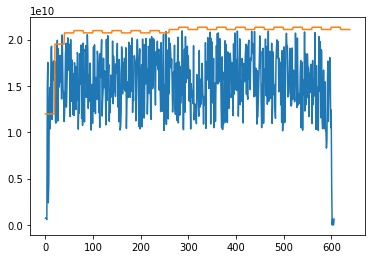

In [40]:
plt.plot(DLaaS_cpu_ts[0], label="Real CPU trace")
plt.plot(ml_rec_cpu_1, label="Autopilot CPU MLR trace")

In [41]:
ml_rec_cpu = [get_granular_rec(get_ml_rec(DLaaS_cpu_agg[i],CPU_BUCKETS),np.mean(CPU_values)) for i in sample_traces]
ml_rec_mem = [get_granular_rec(get_ml_rec(DLaaS_mem_agg[i],MEM_BUCKETS),np.mean(MEM_values)) for i in sample_traces]

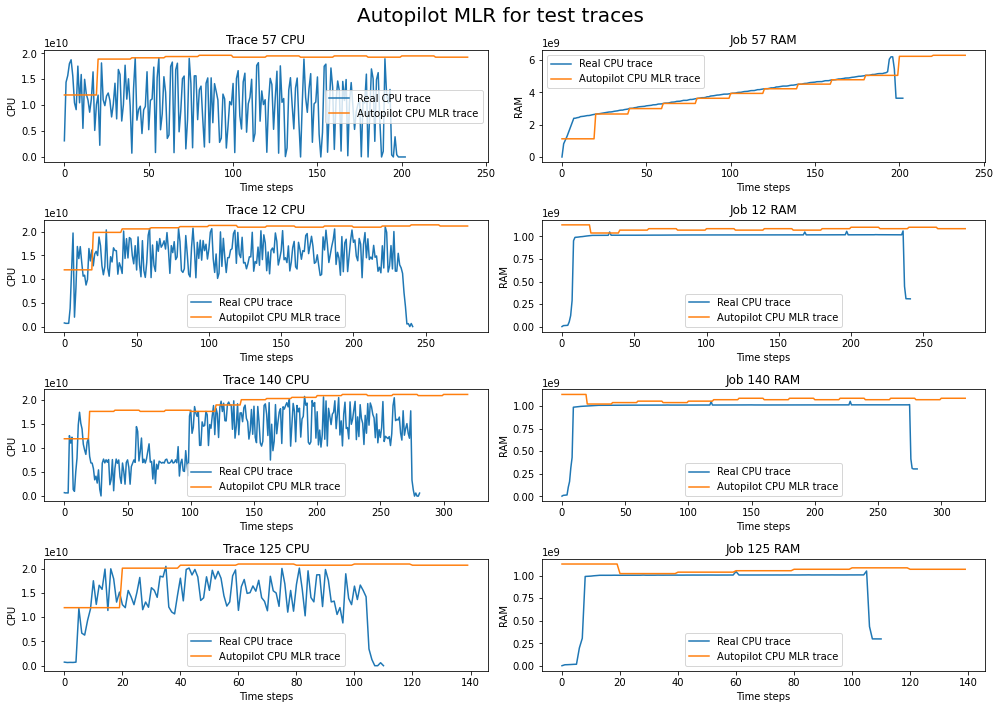

In [42]:
plt.figure(figsize = (14, 10))
plt.suptitle("Autopilot MLR for test traces", size=20)
for i, trace_id in enumerate(sample_traces):
    plt.subplot(420+i*2+1)
    plt.plot(DLaaS_cpu_ts[trace_id], label="Real CPU trace")
    plt.plot(ml_rec_cpu[i], label="Autopilot CPU MLR trace")
    plt.title("Trace "+str(trace_id)+ " CPU")
    plt.xlabel("Time steps")
    plt.ylabel("CPU")
    plt.legend()
    plt.subplot(420+i*2+2)
    plt.plot(DLaaS_mem_ts[trace_id], label="Real CPU trace")
    plt.plot(ml_rec_mem[i], label="Autopilot CPU MLR trace")    
    plt.legend()
    plt.title("Job "+str(trace_id) + " RAM")
    plt.xlabel("Time steps")
    plt.ylabel("RAM")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.savefig(OUTPUT_DIRECTORY+ 'Autopilot_wavg_test_traces.png')

